In [46]:
# -*- coding:utf-8 -*-

import pandas as pd
import xgboost as xgb
from sklearn import metrics
from xgboost.sklearn import XGBClassifier
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

% matplotlib inline

In [47]:
path = '/home/liu/mysoft/pycharm/project/quantist/quantist/kaggle/TalkingData/'
train = pd.read_csv(path + "train.csv", nrows=10000)
test = pd.read_csv(path + "test.csv", nrows=10000)

In [48]:
print(train.shape)
print(train.info())

In [49]:
print(test.shape)
print(test.info())

(10000, 7)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 7 columns):
click_id      10000 non-null int64
ip            10000 non-null int64
app           10000 non-null int64
device        10000 non-null int64
os            10000 non-null int64
channel       10000 non-null int64
click_time    10000 non-null object
dtypes: int64(6), object(1)
memory usage: 547.0+ KB
None


In [50]:
# Preprocess data
#train_sample                 ip  app  device  os  channel click_time  attributed_time  is_attributed  
# test          click_id      ip  app  device  os  channel click_time

train_target = train['is_attributed']
train_data = train.drop(['is_attributed', 'attributed_time'], axis=1)

sub = pd.DataFrame()
sub['click_id'] = test['click_id']
test_data = test.drop(['click_id'], axis=1)

print(train_target[:3])
print(train_data[:3])
print(test_data[:3])

# def preprocess_time(data):
#     # label = ['year', 'month', 'day', 'hour', 'minute']
#     data['year'] = pd.DatetimeIndex(data['click_time']).year
#     data['month'] = pd.DatetimeIndex(data['click_time']).month
#     data['day'] = pd.DatetimeIndex(data['click_time']).day
#     data['hour'] = pd.DatetimeIndex(data['click_time']).hour
#     data['minute'] = pd.DatetimeIndex(data['click_time']).minute
#     data = data.drop(['click_time'], axis=1, inplace=True)
#     return data

# train_data = preprocess_time(train_data)
# test_data = preprocess_time(test_data)

# train_data['year'] = pd.DatetimeIndex(train_data['click_time']).year
# train_data['month'] = pd.DatetimeIndex(train_data['click_time']).month
# train_data['day'] = pd.DatetimeIndex(train_data['click_time']).day
# train_data['hour'] = pd.DatetimeIndex(train_data['click_time']).hour
# train_data['minute'] = pd.DatetimeIndex(train_data['click_time']).minute

# train_target = train_target.values
# train_data = train_data.values
# test_data = test_data.values

def prerocess_time(df):
    """handling time-series data"""
    df['click_time'] = pd.to_datetime(df['click_time']).dt.date
    df['click_time'] = df['click_time'].apply(lambda x: x.strftime('%Y%m%d')).astype(int)
    return df
train_data = prerocess_time(train_data)
test_data = prerocess_time(test_data)
    
X_train, X_test, y_train, y_test = train_test_split(train_data, train_target, test_size=0.2, random_state=0)
# x1, x2, y1, y2 = train_test_split(train, y, test_size=0.1, random_state=99)
print('-----------------')
print(X_train[:3])

0    0
1    0
2    0
Name: is_attributed, dtype: int64
      ip  app  device  os  channel           click_time
0  83230    3       1  13      379  2017-11-06 14:32:21
1  17357    3       1  19      379  2017-11-06 14:33:34
2  35810    3       1  13      379  2017-11-06 14:34:12
       ip  app  device  os  channel           click_time
0    5744    9       1   3      107  2017-11-10 04:00:00
1  119901    9       1   3      466  2017-11-10 04:00:00
2   72287   21       1  19      128  2017-11-10 04:00:00
-----------------
          ip  app  device  os  channel  click_time
7389   30433   14       1  16      439    20171106
9275  106493    3       1  19      280    20171106
2995  112394   18       1  19      107    20171106


cvresult
    test-error-mean  test-error-std  train-error-mean  train-error-std
0            0.0023        0.001122           0.00230         0.000281
1            0.0023        0.001122           0.00230         0.000281
2            0.0023        0.001122           0.00230         0.000281
3            0.0023        0.001122           0.00230         0.000281
4            0.0023        0.001122           0.00230         0.000281
5            0.0023        0.001122           0.00230         0.000281
6            0.0023        0.001122           0.00230         0.000281
7            0.0023        0.001122           0.00230         0.000281
8            0.0023        0.001122           0.00230         0.000281
9            0.0023        0.001122           0.00230         0.000281
10           0.0023        0.001122           0.00230         0.000281
11           0.0023        0.001122           0.00230         0.000281
12           0.0023        0.001122           0.00230         0.0002

Text(0,0.5,'Feature Importance Score')

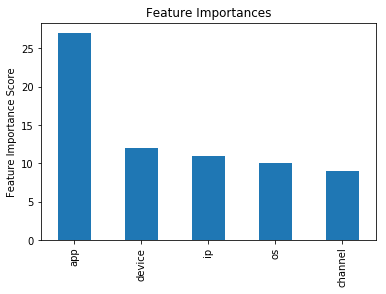

In [51]:
cv_folds=5
early_stopping_rounds=50


xgb1 = XGBClassifier(
        learning_rate =0.1,
        n_estimators=1000,
        max_depth=5,
        min_child_weight=1,
        gamma=0,
        subsample=0.8,
        colsample_bytree=0.8,
        objective= 'binary:logistic',
        nthread=4,
        scale_pos_weight=1,
        seed=27)
xgb_param = xgb1.get_xgb_params()
xgtrain = xgb.DMatrix(train_data.values, label=train_target.values)
cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=xgb1.get_params()['n_estimators'], nfold=cv_folds,
             early_stopping_rounds=early_stopping_rounds)
print('cvresult')
print(cvresult)
print('------------------------------------------------------')
print('Best n_estimators is {0}'.format(cvresult.shape[0]))
xgb1.set_params(n_estimators=cvresult.shape[0])
xgb1.fit(train_data, train_target,eval_metric='auc')

#对训练集预测
dtrain_predictions = xgb1.predict(train_data)
dtrain_predprob = xgb1.predict_proba(train_data)[:,1]
    
#输出模型的一些结果
print("\n关于现在这个模型")
print("准确率 : %.4g" % metrics.accuracy_score(train_target.values, dtrain_predictions))
print("AUC 得分 (训练集): %f" % metrics.roc_auc_score(train_target, dtrain_predprob))
            
feat_imp = pd.Series(xgb1.booster().get_fscore()).sort_values(ascending=False)
feat_imp.plot(kind='bar', title='Feature Importances')
plt.ylabel('Feature Importance Score')
        


In [59]:
# xgtest = xgb.DMatrix(test_data.values)
sub['is_attributed'] = xgb1.predict(test_data, ntree_limit=21)
print(sub[:3])
print('-----------------------------------')
print(type(sub))
print('-----------------------------------')
print(sub.describe())
print('-----------------------------------')
sub.to_csv(path + 'pan05.csv', index=False)
# -rw-rw-r-- 1 liu liu  68K  3月 11 09:38 pan05.csv


   click_id  is_attributed
0         0              0
1         1              0
2         2              0
-----------------------------------
<class 'pandas.core.frame.DataFrame'>
-----------------------------------
          click_id  is_attributed
count  10000.00000        10000.0
mean    4999.50000            0.0
std     2886.89568            0.0
min        0.00000            0.0
25%     2499.75000            0.0
50%     4999.50000            0.0
75%     7499.25000            0.0
max     9999.00000            0.0
-----------------------------------
